In this notebook, we train an AnalogNet architecture for robot navigation (line following). It reaches 75% testing accuracy, on strongly augmented input images.


In [0]:
!nvidia-smi

In [0]:
EPOCHS = 50
BATCH_SIZE = 25
LR = 0.0001

ROUNDING_STEP_CONV = 0.25
ROUNDING_STEP_BIAS = 1.
REG_CONSTANT = 4.

MAX_BIN_RATE = 10

BATCH_SIZE_FC = 10
LR_FC = 0.0001
EPOCHS_FC = 100

# 0 Import data and utils

In [0]:
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

In [0]:
(x_train, y_train),(x_test, y_test) = pickle.load(open('percepbot_dataset.pck', 'rb'))

y_train = y_train - 1
y_test = y_test - 1

# Simulate an input binarization
x_train = np.minimum(x_train, 100) // 100 * 120
x_test = np.minimum(x_test, 100) // 100 * 120

In [0]:
# Sigmoids, whose steepness and bias can be adjusted
# A very steep sigmoid (high bin_rate) simulates a binarization
MAX_BIN_RATE = 50
def binarize_tensor_differentiable(input, thresh, bin_rate):
  """
  out1 = tf.nn.sigmoid(bin_rate*(input[...,:1] - thresh[0]))
  out2 = tf.nn.sigmoid(bin_rate*(input[...,1:2] - thresh[1]))
  out3 = tf.nn.sigmoid(bin_rate*(input[...,2:3] - thresh[2]))
  return tf.concat([out1, out2, out3], axis=-1)
  """
  return tf.nn.sigmoid(bin_rate*(input - thresh))

In [0]:
def test_accuracy_bin_rate(bin_rate_feed):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE)
  for i in range(x_test.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    
    xs = np.expand_dims(x_test[start:stop],-1)
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  print('Testing Acc.: {}'.format(
        accs.mean()))
  
  return accs.mean()

In [0]:
def test_accuracy_bin_rate_fc(bin_rate_feed, verbose=False):
  accs = np.zeros(x_test.shape[0] // BATCH_SIZE_FC)
  for i in range(x_test.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    
    xs = np.expand_dims(x_test[start:stop],-1)
    ys = y_test[start:stop]
    
    current_acc = sess.run(acc_op,
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed})
    accs[i] = current_acc
  
  if verbose:
    print('Testing Acc.: {}'.format(
          accs.mean()))
  return accs.mean()

In [0]:
def custom_pooling(conv_bin):
  sum1 = tf.reduce_sum(conv_bin[:,5:14,0:9,:], axis=[1,2])
  sum2 = tf.reduce_sum(conv_bin[:,14:23,0:9,:], axis=[1,2])
  sum3 = tf.reduce_sum(conv_bin[:,0:9,5:14,:], axis=[1,2])
  sum4 = tf.reduce_sum(conv_bin[:,5:14,5:14,:], axis=[1,2])
  sum5 = tf.reduce_sum(conv_bin[:,14:23,5:14,:], axis=[1,2])
  sum6 = tf.reduce_sum(conv_bin[:,19:28,5:14,:], axis=[1,2])
  sum7 = tf.reduce_sum(conv_bin[:,0:9,14:23,:], axis=[1,2])
  sum8 = tf.reduce_sum(conv_bin[:,5:14,14:23,:], axis=[1,2])
  sum9 = tf.reduce_sum(conv_bin[:,14:23,14:23,:], axis=[1,2])
  sum10 = tf.reduce_sum(conv_bin[:,19:28,14:23,:], axis=[1,2])
  sum11 = tf.reduce_sum(conv_bin[:,5:14,19:28,:], axis=[1,2])
  sum12 = tf.reduce_sum(conv_bin[:,14:23,19:28,:], axis=[1,2])
  
  pool = tf.concat([sum1, sum2, sum3, sum4, sum5, sum6, 
                       sum7, sum8, sum9, sum10, sum11, sum12], axis=1)
  
  return pool

# 1 AnalogNet Architecture 

In [0]:
WIDTH = 3

## 1.1 Network definition

In [0]:
# Define the network
def net1(input, thresh_ph, bin_rate_ph):
  # Convolution
  conv = slim.conv2d(input, WIDTH, [3, 3], rate=1, activation_fn=None,
                     padding='SAME', scope='conv1')
  
  # Output thresholding
  conv_bin = binarize_tensor_differentiable(conv, thresh_ph, bin_rate_ph)
  
  # Custom pooling (central division + sum overlapping)
  #pool = custom_pooling(conv_bin)
  pool = slim.avg_pool2d(conv_bin, [32, 32], 
                       stride=[32, 32], padding='SAME')
  
  # Flatten + dense
  flat = tf.layers.flatten(pool)
  dense = tf.layers.dense(flat, 50, name='dense1', activation=tf.nn.relu)
  out = tf.layers.dense(dense, 3, name='dense2')
  
  return out

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE,96,96,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

In [0]:
# Create session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
# Define regulariser
def customRegularizerConv(x):
  return tf.math.cos(2/ROUNDING_STEP_CONV*np.pi*(x-ROUNDING_STEP_CONV/2))+1.

def customRegularizerBias(x):
  return tf.math.cos(2/ROUNDING_STEP_BIAS*np.pi*(x-ROUNDING_STEP_BIAS/2))+1.

with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')


reg_losses = tf.reduce_mean(customRegularizerConv(w1))

reg_factor_ph = tf.placeholder(tf.float32)
loss_with_reg_op = loss_op + reg_factor_ph * reg_losses

lr_ph = tf.placeholder(tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_op = opt.minimize(loss_with_reg_op)
sess.run(tf.variables_initializer(opt.variables()))

## 1.2 Training

In [0]:
# Bin then reg
for epoch in range(EPOCHS*12):
  if epoch < EPOCHS * 4:
    lr_feed = LR
    reg_factor_feed = 0.
    bin_rate_feed = 1.
  elif epoch < EPOCHS * 8:
    lr_feed = LR / 2.
    reg_factor_feed = 0.
    bin_rate_feed = MAX_BIN_RATE + 1
  else:
    lr_feed = LR / 4.
    reg_factor_feed = REG_CONSTANT
    bin_rate_feed = MAX_BIN_RATE + 1
    
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE)
  for i in range(x_train.shape[0] // BATCH_SIZE):
    start = i * BATCH_SIZE
    stop = start + BATCH_SIZE
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss, out_label_res = sess.run([opt_op, loss_op, out_label_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  lr_ph: lr_feed,
                                  reg_factor_ph: reg_factor_feed,
                                  bin_rate_ph: bin_rate_feed})

    losses[i] = current_loss
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  test_accuracy_bin_rate(bin_rate_feed)

Epoch 1 completed, average training loss is 1.0334379076957703
Testing Acc.: 0.48000000025096695
Epoch 2 completed, average training loss is 0.9864352697675879
Testing Acc.: 0.5515789436666589
Epoch 3 completed, average training loss is 0.9496184194629843
Testing Acc.: 0.5705263175462422
Epoch 4 completed, average training loss is 0.913963111964139
Testing Acc.: 0.545263157863366
Epoch 5 completed, average training loss is 0.8808412700891495
Testing Acc.: 0.5242105271471175
Epoch 6 completed, average training loss is 0.846235918727788
Testing Acc.: 0.5199999993568972
Epoch 7 completed, average training loss is 0.8152537684548985
Testing Acc.: 0.5305263149110895
Epoch 8 completed, average training loss is 0.7903432182290338
Testing Acc.: 0.5431578943603917
Epoch 9 completed, average training loss is 0.7612653483044017
Testing Acc.: 0.5557894722411507
Epoch 10 completed, average training loss is 0.7394209463487972
Testing Acc.: 0.5705263120563406
Epoch 11 completed, average training loss

In [0]:
test_accuracy_bin_rate(bin_rate_feed)

Testing Acc.: 0.757894734802999


0.757894734802999

In [0]:
# Save models, for not having to fully retrain it each time.

saver = tf.train.Saver()
saver.save(sess, 'perceptbot_1_layer_'+str(WIDTH)+'_hard_sep_kernels_bin_reg/model.ckpt')

'perceptbot_1_layer_3_hard_sep_kernels_bin_reg/model.ckpt'

In [0]:
!zip -r perceptbot_1_layer_3_hard_sep_kernels_bin_reg.zip perceptbot_1_layer_3_hard_sep_kernels_bin_reg

  adding: perceptbot_1_layer_3_hard_sep_kernels_bin_reg/ (stored 0%)
  adding: perceptbot_1_layer_3_hard_sep_kernels_bin_reg/model.ckpt.data-00000-of-00001 (deflated 17%)
  adding: perceptbot_1_layer_3_hard_sep_kernels_bin_reg/model.ckpt.meta (deflated 85%)
  adding: perceptbot_1_layer_3_hard_sep_kernels_bin_reg/model.ckpt.index (deflated 41%)
  adding: perceptbot_1_layer_3_hard_sep_kernels_bin_reg/checkpoint (deflated 42%)


## 1.3 Re-training FC after rounding the conv kernels

In [0]:
!unzip perceptbot_1_layer_3_kernels_bin_reg.zip

Archive:  one_layer_bin_reg.zip
   creating: one_layer_bin_reg/
   creating: one_layer_bin_reg/.ipynb_checkpoints/
  inflating: one_layer_bin_reg/checkpoint  
  inflating: one_layer_bin_reg/model.ckpt.index  
  inflating: one_layer_bin_reg/model.ckpt.data-00000-of-00001  
  inflating: one_layer_bin_reg/model.ckpt.meta  


### 1.3.1 Reload Network

In [0]:
# Define the graph
tf.reset_default_graph()

in_image_ph = tf.placeholder(tf.float32, [BATCH_SIZE_FC,96,96,1])
gt_label_ph = tf.placeholder(tf.uint8)
thresh = tf.Variable(tf.random.normal([WIDTH]), name='out_thresholds')
bin_rate_ph = tf.placeholder(tf.float32, ())

out_label_op = net1(in_image_ph, thresh, bin_rate_ph)

pred_op = tf.dtypes.cast(
            tf.keras.backend.argmax(out_label_op),
            tf.uint8)

loss_op = tf.reduce_mean(
          tf.keras.backend.sparse_categorical_crossentropy(gt_label_ph,
                                                           out_label_op,
                                                           from_logits=True))

acc_op = tf.contrib.metrics.accuracy(gt_label_ph, pred_op)

saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state('perceptbot_1_layer_'+str(WIDTH)+'_hard_aug_kernels_bin_reg')
saver.restore(sess, ckpt.model_checkpoint_path)
test_accuracy_bin_rate_fc(MAX_BIN_RATE)

0.9106382933702875

### 1.3.2 Round weights

In [0]:
with tf.variable_scope('conv1', reuse=True) as scope_conv:
  w1 = tf.get_variable('weights')

Testing Acc.: 0.9106382933702875


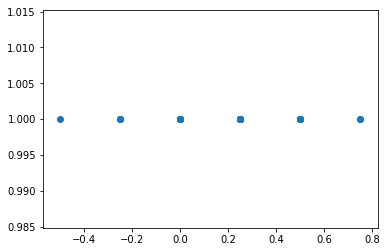

In [0]:
# Rounding operation
rounding_weights1_op = tf.assign(w1, 
                          tf.round(w1/ROUNDING_STEP_CONV)*ROUNDING_STEP_CONV)

_ = sess.run(rounding_weights1_op)

test_accuracy_bin_rate_fc(MAX_BIN_RATE, verbose=True)

# Show final distribution of weights
w1_values = sess.run(w1)

kernel_values = (list(w1_values.flatten()))
fig = plt.figure()
plt.scatter(kernel_values, [1]*len(kernel_values))


### 1.3.3 Retrain FC only

In [0]:
with tf.variable_scope('dense1', reuse=True) as scope_conv:
  fc1_k = tf.get_variable('kernel')
  fc1_b = tf.get_variable('bias')

with tf.variable_scope('dense2', reuse=True) as scope_conv:
  fc2_k = tf.get_variable('kernel')
  fc2_b = tf.get_variable('bias')

lr_ph = tf.placeholder(tf.float32)
opt_fc = tf.train.AdamOptimizer(learning_rate=lr_ph, name='Adam_reg')
opt_fc_op = opt_fc.minimize(loss_op, var_list=[fc1_k, fc1_b,
                                               fc2_k, fc2_b])

sess.run(tf.variables_initializer(opt_fc.variables()))

In [0]:
sess.run(fc1_k).shape

(27, 50)

In [0]:
# Very long training:
bin_rate_feed = MAX_BIN_RATE + 1.
max_test_accuracy = 0.
for epoch in range(EPOCHS_FC*10):
  if epoch < EPOCHS_FC:
    lr_feed = LR_FC*8
  elif epoch < 3*EPOCHS_FC:
    lr_feed = LR_FC * 4
  elif epoch < 6*EPOCHS_FC:
    lr_feed = LR_FC * 2
  elif epoch < 8:
    lr_feed = LR_FC
  elif epoch < 9:
    lr_feed = LR_FC / 2.
  else:
    lr_feed = LR_FC / 5.
  random_perm = np.random.permutation(x_train.shape[0])
  losses = np.zeros(x_train.shape[0] // BATCH_SIZE_FC)
  for i in range(x_train.shape[0] // BATCH_SIZE_FC):
    start = i * BATCH_SIZE_FC
    stop = start + BATCH_SIZE_FC
    selected = random_perm[start:stop]
    
    xs = np.expand_dims(x_train[selected],-1)
    ys = y_train[selected]
    
    _, current_loss = sess.run([opt_fc_op, loss_op],
                       feed_dict={in_image_ph: xs,
                                  gt_label_ph: ys,
                                  bin_rate_ph: bin_rate_feed,
                                  lr_ph: lr_feed})

    losses[i] = current_loss
  
  current_test_accuracy = test_accuracy_bin_rate_fc(bin_rate_feed)
  # Save best model
  if current_test_accuracy > max_test_accuracy:
    saver.save(sess, 'one_layer_best_fc_retrain/model.ckpt')
    max_test_accuracy = current_test_accuracy
  
  print('Epoch {} completed, average training loss is {}'.format(
          epoch+1, losses.mean()))
  print('Testing Acc.: {}'.format(current_test_accuracy))
  
# Restore best model
ckpt = tf.train.get_checkpoint_state('one_layer_best_fc_retrain')
saver.restore(sess, ckpt.model_checkpoint_path)
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Epoch 1 completed, average training loss is 0.23349127035822953
Testing Acc.: 0.7382978720867888
Epoch 2 completed, average training loss is 0.22459579010804495
Testing Acc.: 0.7595744665632856
Epoch 3 completed, average training loss is 0.2200521212238986
Testing Acc.: 0.7659574471255566
Epoch 4 completed, average training loss is 0.21849781476162575
Testing Acc.: 0.7553191494117392
Epoch 5 completed, average training loss is 0.21922862177362312
Testing Acc.: 0.7340425544596733
Epoch 6 completed, average training loss is 0.21598839273189638
Testing Acc.: 0.7595744678314696
Epoch 7 completed, average training loss is 0.21263081966353967
Testing Acc.: 0.7617021266450273
Epoch 8 completed, average training loss is 0.21063140126968827
Testing Acc.: 0.7723404240417988
Epoch 9 completed, average training loss is 0.20967442475192183
Testing Acc.: 0.7638297867267689
Epoch 10 completed, average training loss is 0.20294536304500727
Testing Acc.: 0.7659574468085106
Epoch 11 completed, average tr

In [0]:
_ = test_accuracy_bin_rate_fc(bin_rate_feed, verbose=True)

Testing Acc.: 0.9692000025510787


## 1.4 Extract conv weights

In [0]:
w1_values

array([[[[ 0.5 ,  0.  , -0.25]],

        [[ 0.25,  0.75,  0.5 ]],

        [[ 0.25,  0.  ,  0.5 ]]],


       [[[ 0.  , -0.25,  0.25]],

        [[ 0.25, -0.5 ,  0.25]],

        [[ 0.  ,  0.75,  0.25]]],


       [[[-0.25,  0.25,  0.5 ]],

        [[ 0.5 ,  0.  ,  0.  ]],

        [[ 0.5 ,  0.25,  0.25]]]], dtype=float32)

In [0]:
sess.run(thresh)

In [0]:
with open('NP_WEIGHTS.pck', 'wb') as f:
  pickle.dump(w1_values, f)